# Setup stuff

In [1]:
%matplotlib inline

In [2]:
import skip_phrase
from skip_phrase.dataset_readers.reader import *
from skip_phrase.models.skip_phrase import *
from skip_phrase.predictors.predictor import *

/home/ubuntu/anaconda3/envs/umt/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from allennlp.models.archival import load_archive
from allennlp.service.predictors import Predictor

In [4]:
import sys
sys.executable

'/home/ubuntu/anaconda3/envs/umt/bin/python'

In [5]:
from scipy import spatial

In [6]:
from allennlp.models.archival import archive_model
archive_model("models/skip_phrase_news")
archive_model??

Signature: archive_model(serialization_dir:str, weights:str='best.th', files_to_archive:Dict[str, str]=None) -> None
Source:   
def archive_model(serialization_dir: str,
                  weights: str = _DEFAULT_WEIGHTS,
                  files_to_archive: Dict[str, str] = None) -> None:
    """
    Archive the model weights, its training configuration, and its
    vocabulary to `model.tar.gz`. Include the additional ``files_to_archive``
    if provided.

    Parameters
    ----------
    serialization_dir: ``str``
        The directory where the weights and vocabulary are written out.
    weights: ``str``, optional (default=_DEFAULT_WEIGHTS)
        Which weights file to include in the archive. The default is ``best.th``.
    files_to_archive: ``Dict[str, str]``, optional (default=None)
        A mapping {hocon_key -> filename} of supplementary files to include
        in the archive.
    """
    weights_file = os.path.join(serialization_dir, weights)
    if not os.path.exists(weights

In [7]:
#archive = load_archive('models/europarl_full/model.tar.gz')
#archive = load_archive('models/europarl_v2/model.tar.gz')
archive = load_archive('models/skip_phrase_news/model.tar.gz')

In [8]:
def cos_sim(p1, p2):
    return 1 - spatial.distance.cosine(p1, p2)

In [9]:
def pred_cos_sim(s1, s2):
    p1 = predictor.predict_json(predictor.load_line(s1))['pivot_phrase_embedding']
    p2 = predictor.predict_json(predictor.load_line(s2))['pivot_phrase_embedding']
    return cos_sim(p1, p2)

In [10]:
??Predictor.from_archive

Signature: Predictor.from_archive(archive:allennlp.models.archival.Archive, predictor_name:str) -> 'Predictor'
Source:   
    @classmethod
    def from_archive(cls, archive: Archive, predictor_name: str) -> 'Predictor':
        """
        Instantiate a :class:`Predictor` from an :class:`~allennlp.models.archival.Archive`;
        that is, from the result of training a model. Optionally specify which `Predictor`
        subclass; otherwise, the default one for the model will be used.
        """
        config = archive.config

        dataset_reader_params = config["dataset_reader"]
        dataset_reader = DatasetReader.from_params(dataset_reader_params)

        model = archive.model
        model.eval()

        return Predictor.by_name(predictor_name)(model, dataset_reader)
File:      ~/research/skip_phrase/allennlp/service/predictors/predictor.py
Type:      method


In [11]:
predictor = Predictor.from_archive(archive, 'skip_phrase_predictor')

In [12]:
p1 = predictor.predict_json(predictor.load_line("good"))['pivot_phrase_embedding']

In [13]:
p2 = predictor.predict_json(predictor.load_line("aweasome"))['pivot_phrase_embedding']

In [14]:
cos_sim(p1, p2)

0.6553340268139286

In [15]:
words = open('models/europarl_vocab/words.txt', 'r')

In [16]:
words = words.readlines()

In [17]:
words = [w[:-1] for w in words]

In [18]:
len(words)

52115

In [19]:
all_words = words

# Plot

In [20]:
NUM_WORDS_TO_PLOT = 300

In [21]:
words = all_words[1:NUM_WORDS_TO_PLOT]

(-211.49014, 216.95656)

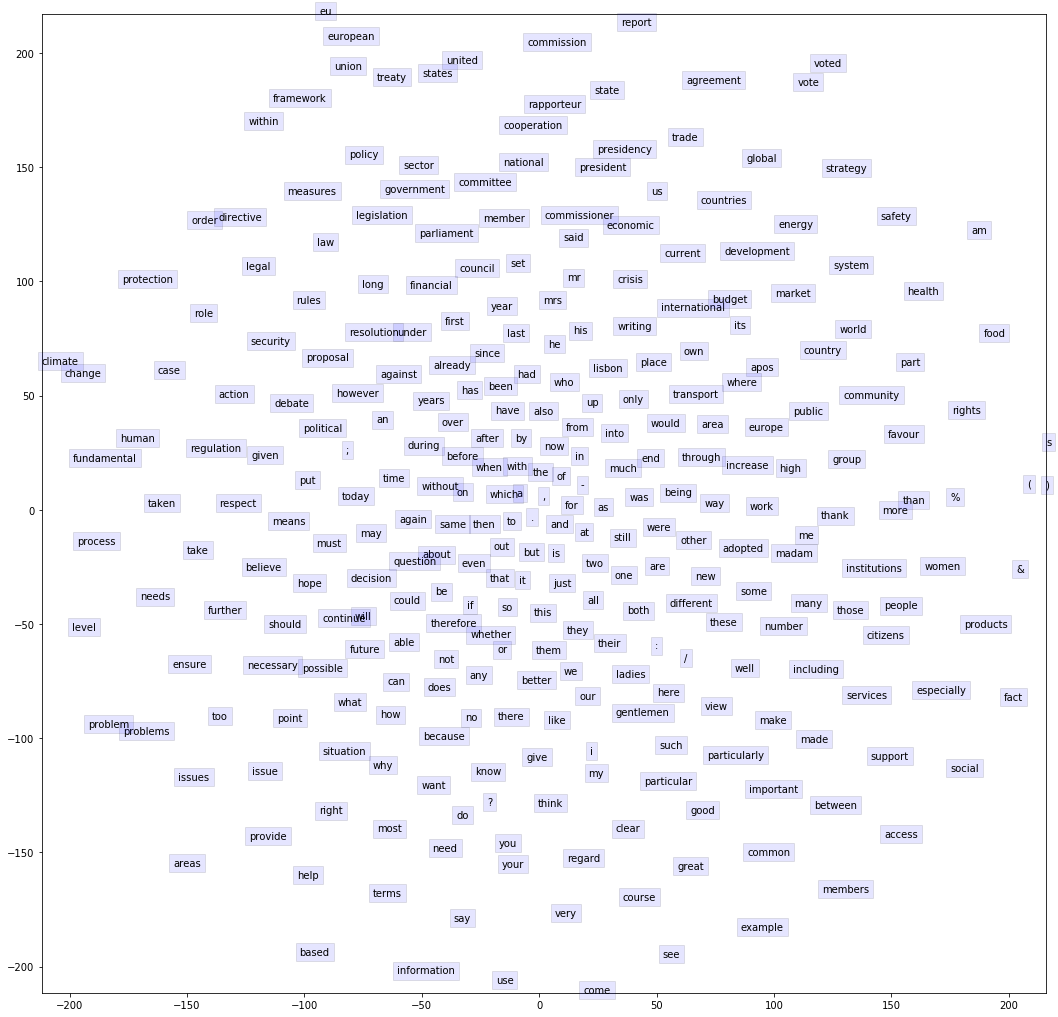

In [22]:
import os
import pickle
import argparse
import matplotlib
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

mt = 'tsne'
if mt == 'pca':
    model = PCA(n_components=2)
elif mt == 'tsne':
    model = TSNE(n_components=2, perplexity=30, init='pca', method='exact', n_iter=5000)
X = [predictor.predict_json(predictor.load_line(word))['pivot_phrase_embedding'] for word in words]
X = model.fit_transform(X)
plt.figure(figsize=(18, 18))
for i in range(len(X)):
    plt.text(X[i, 0], X[i, 1], words[i], bbox=dict(facecolor='blue', alpha=0.1))
plt.xlim((np.min(X[:, 0]), np.max(X[:, 0])))
plt.ylim((np.min(X[:, 1]), np.max(X[:, 1])))

# Similarity

In [23]:
s1 = '1'
s2 = '6'
pred_cos_sim(s1, s2)

0.6281705256686019

# Dataset evaluation

tar -czvf archive.tar.gz stuff

In [24]:
f = open("../data/phrase_eval/raw", 'r')

In [25]:
pairs = f.readlines()

In [26]:
pairs = pairs[1:]

In [27]:
pairs = [p[0:-1] for p in pairs]

In [28]:
pairs = [p.split() for p in pairs]

In [29]:
pairs[1]

['participant1', 'verbobjects', '2', 'war', 'fight', 'battle', 'win', '5']

In [30]:
s1 = 'state of the art'
s2 = 'contemporary methods'
pred_cos_sim(s1, s2)

0.37235342134943483

In [31]:
TYPE = 1
PHR1_W1 = 3
PHR1_W2 = 4
PHR2_W1 = 5
PHR2_W2 = 6
Y = 7

In [32]:
pairs[0][Y]

'5'

In [33]:
set([p[TYPE] for p in pairs])

{'adjectivenouns', 'compoundnouns', 'verbobjects'}

In [34]:
sims_adjectivenouns = []
sims_compoundnouns = []
sims_verbobjects = []

true_scores_adjectivenouns = []
true_scores_compoundnouns = []
true_scores_verbobjects = []

for i, p in enumerate(pairs):
    phr1 = " ".join([p[PHR1_W1], p[PHR1_W2]])
    phr2 = " ".join([p[PHR2_W1], p[PHR2_W2]])
    sim = pred_cos_sim(phr1, phr2)

    t = p[TYPE]
    if t == 'adjectivenouns':        
        true_scores_adjectivenouns.append(int(p[Y]))
        sims_adjectivenouns.append(sim)
    if t == 'compoundnouns':
        true_scores_compoundnouns.append(int(p[Y]))
        sims_compoundnouns.append(sim)
    if t == 'verbobjects':
        true_scores_verbobjects.append(int(p[Y]))
        sims_verbobjects.append(sim)

In [35]:
from scipy.stats import spearmanr

In [144]:
spearmanr(sims_adjectivenouns, true_scores_adjectivenouns)

SpearmanrResult(correlation=0.2533701769354423, pvalue=7.432591393720084e-30)

In [145]:
spearmanr(sims_compoundnouns, true_scores_compoundnouns)

SpearmanrResult(correlation=0.42460940856383694, pvalue=6.183383032951577e-86)

In [146]:
spearmanr(sims_verbobjects, true_scores_verbobjects)

SpearmanrResult(correlation=0.2736933170080909, pvalue=9.623361802181996e-35)